# CK Mapping

## Model Creation

In [1]:
from openai import OpenAI
import networkx as nx
import matplotlib.pyplot as plt
import markdown
import re
from IPython.display import display, Markdown

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
import re

In [5]:
import matplotlib.pyplot as plt

In [6]:
api_key = "API_KEY"
client = OpenAI(api_key = api_key)

In [7]:
# initial concept input is title and product description
class Concept:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI's refined description
        self.type = "Concept"  # Tracks as a concept

class Knowledge:
    def __init__(self, name, description):
        self.name = name
        self.description = description  # AI’s deeper reasoning carried forward
        self.type = "Knowledge"  # Tracks as knowledge
        
# 🔹 Graph System for Tracking C-K Transitions 🔹
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()
        self.history = []
        self.transition_history = []

    def add_node(self, name, nodetype, description):
        """Generalized method to add either a Concept or Knowledge to the graph."""
        self.graph.add_node(name, type=nodetype, description=description)

    def add_edge(self, parent, child, transformation):
        """Tracks transitions between concepts and knowledge dynamically."""
        self.graph.add_edge(parent.name, child.name, type=transformation)
        self.history.append((parent.name, child.name, transformation))
        self.transition_history.append(transformation)
        print(f"🔄 {transformation}: {parent.name} → {child.name}")

    def visualize_graph(self):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(self.graph)
        labels = nx.get_edge_attributes(self.graph, "type")

        nx.draw(self.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3500, font_size=10)
        nx.draw_networkx_edge_labels(self.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()
        

In [8]:
def get_embedding(text, model = "text-embedding-3-small"):
    response = client.embeddings.create(input=text, model=model, dimensions = 512)
    return response.data[0].embedding

In [9]:
def cosine_similarity(vec1, vec2):
    vec1 = np.array(vec1)
    vec2 = np.array(vec2)
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    cosine_sim = dot_product / (norm_vec1 * norm_vec2)
    
    return cosine_sim

In [10]:
def extract_knowledge_details(text):
    title_match = re.search(r'Knowledge Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Knowledge Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [11]:
def extract_concept_details(text):
    title_match = re.search(r'Concept Title:\s*(.*)', text, re.IGNORECASE)
    description_match = re.search(r'Concept Description:\s*(.*)', text, re.IGNORECASE)

    title = title_match.group(1) if title_match else None
    description = description_match.group(1) if description_match else None

    return title, description

In [12]:
def penalize_repetition_check(concept_database, number_concept):
    sys_prompt = f"""
    You are a C-K Theory expert. In the input, I provided {number_concept} sets of consecutive C-->C operations where each group of concepts are separated by a comma and contain a concept title and a concept description. In a C-->C operation the concepts are expanding by partitioning and exploring new attributes. Do these expanding concepts still hold significant ambiguity or unexplored potential that cannot yet be resolved or validated? Note, that this path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on determining whether there exists truly novel propositions that can transform or extend the knowledge space? Are the iterations becoming repetitive in its idea and content? These are questions you ask yourself while determining whether to say Yes or No on whether or not we should continue doing C-->C operation.
    """
    prompt = ', '.join(concept_database)
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=0.5
        )
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Respond with a "yes" or "no". Do not include periods in your response.
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [13]:
def givenC_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f"""
    C-K THEORY EXPERT DECISION SYSTEM 
    Your role is to evaluate the current concept/knowledge and determine the optimal transformation.
    The topic you are working on is to {topic}
   
    ---
    Current Concept: {title} 
    Description: {description}
    Past Transformations: {past_transformations}
    Existing Knowledge Base: {past_knowledge}
    Context: 
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step represents the design process.
    Note, the definition of design process in this regard is the process by which a concept generates other concepts or is transformed into knowledge. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.

  🔍 Your Goal:
    1️⃣ Evaluate whether to go from concept to concept or concept to knowledge. Ensure your decision represents the design process based on the information of the current concept, description, past transformations, and existing knowledge base.
    - C-->C (Concept Expansion): Use this if the concept still holds significant ambiguity or unexplored potential that cannot yet be resolved or validated with the existing knowledge base. This path is chosen when further ideation or exploration is necessary to refine the concept or when the concept introduces novel elements that challenge existing knowledge boundaries. Focus on exploring whether there exists truly novel propositions that can transform or extend the knowledge space.
    - C-->K (Concept to Knowledge): Choose this path when the concept has been sufficiently refined and aligns with the existing knowledge base, allowing it to be tested, validated, or implemented. This transition is appropriate when the concept can be logically integrated into the knowledge space, resolving its ambiguity and proving its feasibility or truthfulness within the current understanding. Note, the integration of new knowledge is not just about validation but also about whether the concept can enrich the knowledge space. If it meets some of these criteria, it is time to go to K.
Determine whether we should go to concept or knowledge. 
 
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from concept to concept or concept to knowledge. Respond with either 'Concept' for C-->C or 'Knowledge' for C-->K 
    """
    
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content

In [14]:
def givenK_determine_c_or_k(title, description, past_transformations, past_knowledge, topic):
    prompt = f""""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
 ---
    Current Knowledge: {title}
    Description: {description}
    Past Transformations: {past_transformations}
     Context:
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation.
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.

Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    🔍 Your Goal:
    1️⃣ Evaluate Possible Transformations Dynamically:
    - K→C (Concept Expansion): Used when existing knowledge suggests new concepts or when you suspect new insights from K can lead to the generation of new concepts.
    - K→K (Concept to Knowledge): Used to expand the knowledge space by adding new validated propositions or insights. This is typically performed when new information is created usually from things like C→K.

Use the Current Knowledge Space for reference: [{past_knowledge}]
    """
    
    sys_prompt = """
    You are an expert in C-K Theory. Decide whether we should transform from knowledge to concept or knowledge to knowledge. Respond with either 'Concept' for K-->C or 'Knowledge' for K-->K"
    """
    
    response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
    
    response_1 = response.choices[0].message.content
    follow_up_prompt = """
    Please answer with only one word: 'Concept' or 'Knowledge'. Do not include periods or extra information in you response. Which should we choose?".
    """
    
    response_2 = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": sys_prompt},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response_1},
                {"role": "user", "content": follow_up_prompt}
            ],
            temperature=0
        )
    
    return response_2.choices[0].message.content
    

In [15]:
def scraped_data_to_string(df_scraped_data):
    """
    This takes in a scraped data from the dataframe and turn it into a string of knowledge bases for LLM inputs
    """
    formatted_strings = []
    for index, row in df_scraped_data.iterrows():
        # format the string for each row
        formatted_string = f"Title: {row['Title']} Description: {row['Description']}"
        # append the formatted string to the list
        formatted_strings.append(formatted_string)

    result = ''.join(formatted_strings)
    return result

In [16]:
def determine_operation_concept2(concept_title, concept_description, df_knowledge, transition_history, topic, force_k, concept_space):
    past_concepts = ', '.join(transition_history)
    past_transitions = ', '.join(transition_history)
    past_knowledge = scraped_data_to_string(df_knowledge)
    determine_operation_direc = givenC_determine_c_or_k(concept_title, concept_description, past_transitions, past_knowledge, topic)
    if force_k is True:
        transition_choice = 'C-->K' 
        prompt_c_to_k = f"""
    C-K THEORY EXPERT DECISION SYSTEM
You are an AI Specializing in Design Innovation using C-K  Theory.
Your role is to evaluate the current concept.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
Existing Knowledge Space: {past_knowledge}
Description: {concept_description}
Past Transitions: {past_transitions}
Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
            """

        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt_c_to_k},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
    else: 
        if determine_operation_direc.lower() == "concept":
            transition_choice = 'C-->C'
            prompt_c_to_c = f"""
        C-K THEORY EXPERT DECISION SYSTEM
        You are an AI Specializing in Design Innovation using C-K  Theory.
        Your role is to evaluate the current concept.
        The topic you are working on is to {topic}
        You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
        Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
        Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
        Existing Knowledge Space: {past_knowledge}
        Current Concept: {concept_title} 
        Description: {concept_description}  
        Past Transitions: {past_transitions}
        Your goal is to identify specific areas of the concept that remains unexplored or ambiguous. Utilize the existing knowledge base as a reference to guide your exploration. The goal is to get truly novel propositions and attributes that can enhance the concept space and lead to new discovery in the knowledge space.
        Provide a new concept title and description.
          """


            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_c},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content

        elif determine_operation_direc.lower() == "knowledge":
            transition_choice = 'C-->K' 
            prompt_c_to_k = f"""
        C-K THEORY EXPERT DECISION SYSTEM
    You are an AI Specializing in Design Innovation using C-K  Theory.
    Your role is to evaluate the current concept.
    The topic you are working on is to {topic}
    You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
    Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
    Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
    Existing Knowledge Space: {past_knowledge}
    Current Concept: {concept_title}
    Description: {concept_description}
    Past Transitions: {past_transitions}
    Your goal is to test or validate a concept against existing knowledge. You need to determine its feasibility and translate it into new knowledge learned.
                """

            title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
            desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
            response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k}
                ],
                temperature=1
            )

            response_title = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": title_prmpt}
                ],
                temperature=0
            )

            response_desc = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt_c_to_k},
                    {"role": "assistant", "content": response.choices[0].message.content},
                    {"role": "user", "content": desc_prmpt}
                ],
                temperature=0
            )

            final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
            new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
            df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
            # compute embeddings only for new row
#             new_index = df_knowledge.index[-1]
#             df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#             df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)

        else:
            error_message = f"Error: The operation direction '{determine_operation_direc}' is not recognized. It must be either 'concept' or 'knowledge'."
            raise ValueError(error_message)
    return final_title, final_desc, transition_choice, df_knowledge

In [17]:
def determine_operation_knowledge(knowledge_title, knowledge_description, df_knowledge, transition_history, topic, concept_space):
    """Input: concept_title (text), concept_description (text), dataframe knowledge space (pandas df), past_transitions
    Output: chosen operation and new concept/knowledge title + description"""
    past_concepts = ', '.join(concept_space)
    past_transitions = ', '.join(transition_history)
    transition_choice = None
    past_knowledge = scraped_data_to_string(df_knowledge)
    K_or_C = givenK_determine_c_or_k(knowledge_title, knowledge_description, past_transitions, past_knowledge, topic)
    
    if K_or_C.lower() == "knowledge":
        transition_choice = "K-->K"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
 Use the current Knowledge Space for reference: [{past_knowledge}]
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to expand the knowledge space by adding new validated propositions or insights. 

        """
        
        response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        new_data = pd.DataFrame({
            'Title': [final_title],
            'Description': [final_desc]
        })
        df_knowledge = pd.concat([df_knowledge, new_data], ignore_index = True)
        # compute embeddings only for new row
#         new_index = df_knowledge.index[-1]
#         df_knowledge.at[new_index, 'Title_Embeddings'] = get_embedding(final_title)
#         df_knowledge.at[new_index, 'Description_Embeddings'] = get_embedding(final_desc)
        
    elif K_or_C.lower() == "concept":
        transition_choice = "K-->C"
        prompt = f"""
        C-K THEORY EXPERT DECISION SYSTEM
You are an AI specializing in Design Innovation using C-K Theory.
Your role is to evaluate the current knowledge.
The topic you are working on is to {topic}
You are an AI expert in C-K Theory for design innovation. Your goal is to apply design theory principles dynamically, ensuring that each step is strategically progressing towards innovation. 
Knowledge Space (K) - This is the space where propositions have a logical status, meaning they can be true or false. It represents what is known and accepted by a designer. The logical status can be based on standard or non-standard logic systems, but for simplicity, it is often considered as classic true or false logic.
Concept Space (also C): This space consists of propositions or groups of propositions that do not have a logical status in K. Concepts are essentially ideas or properties that cannot be proven true or false within the current knowledge space. They are the starting point for design, as they represent new possibilities that are not yet part of the existing knowledge.
 ---
  Use the Knowledge Space to help guide your thinking.: [{past_knowledge}]
 Current Knowledge: {knowledge_title}
 Description: {knowledge_description}
 Past Transformations: {past_transitions}
 Your goal is to to use existing knowledge to suggest new concepts. Instead, add new propositions and novelty to the concept space.
        """
        
        response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": 'You are an expert in C-K Theory'},
                    {"role": "user", "content": prompt}
                ],
                temperature=1
            )
        
        title_prmpt = """Transform your response into a single title adhering strictly to the following format. [insert title]"""
        desc_prmpt = """Transform your response into a description adhering strictly to the following format. [insert description]"""
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt}
            ],
            temperature=1
        )
        
        response_title = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": title_prmpt}
            ],
            temperature=0
        )
        
        response_desc = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {"role": "system", "content": 'You are an expert in C-K Theory'},
                {"role": "user", "content": prompt},
                {"role": "assistant", "content": response.choices[0].message.content},
                {"role": "user", "content": desc_prmpt}
            ],
            temperature=0
        )

        final_title, final_desc = response_title.choices[0].message.content, response_desc.choices[0].message.content
        
    else: 
        error_message = f"Error: The operation direction '{K_or_C}' is not recognized. It must be either 'concept' or 'knowledge'."
        raise ValueError(error_message)
        
    
    return final_title, final_desc, transition_choice, df_knowledge
 

In [18]:
class ConceptKnowledgeSystem:
    def __init__(self):
        self.graph = nx.DiGraph()

    def add_node(self, name, type, description):
        self.graph.add_node(name, type=type, description=description)

    def add_edge(self, parent_name, child_name, transition_choice):
        self.graph.add_edge(parent_name, child_name, transition=transition_choice)


In [19]:
system = ConceptKnowledgeSystem()

In [20]:
df_know_embed = pd.read_csv('data/amazon links/hammering_nail_req.csv')

In [21]:
current_type = "concept"
current_desc = "A nail holder avoiding to hurt one's hand while hammering"
current_title = "Avanti nail holder"
past_transitions = []
# df_know_embed = pd.read_pickle('data/amazon links/amazon_nail_embedding.pkl')
topic = "design a creative and unique nail holder for when a person is hammering a nail."
list_concepts = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
concept_space = ["Concept Title: Avanti nail holder + Concept Desc: A nail holder avoiding to hurt one's hand while hammering"]
num_C_repeat = 0
force_k = False
similarity_lists = []
avg_iteration_sim = []

In [22]:
for i in range(50):
    if current_type == "concept":
        # Determine the next operation from the concept
        new_title, new_desc, transition_choice, new_df = determine_operation_concept2(current_title, current_desc, df_know_embed, past_transitions, topic, force_k, concept_space)
        
    elif current_type == "knowledge": 
        new_title, new_desc, transition_choice, new_df = determine_operation_knowledge(current_title, current_desc, df_know_embed, past_transitions, topic, concept_space)
    
    else:
        print("there was an issue in identifying current type")
        pass
    
    system.add_node(current_title, current_type, current_desc)
    if transition_choice in ["C-->C", "K-->C"]:
        new_type = "concept"
    elif transition_choice in ["C-->K", "K-->K"]:
        new_type = "knowledge"
    else:
        print("there was an issue in getting the new type")
        pass
    print(f"Iteration {i+1}:")
    print(f"  Current Title: {current_title}")
    print(f"  Current Description: {current_desc}")
    print(f"  Transition: {transition_choice}")
    print(f"  New Title: {new_title}")
    print(f"  New Description: {new_desc}")
    print(f"  Past Transitions: {past_transitions}")
    print("-" * 40)
    
    system.add_edge(current_title, new_title, transition_choice)
    past_transitions.append(transition_choice)
    concept_space.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
    embedded_concept_space = [get_embedding(concept) for concept in concept_space]
    
    if len(embedded_concept_space) < 2:
        pass
    else:
        avg_sims = []
        iteration_similarities = []
        count = 0
        total_similarity = 0
        for i in range(len(embedded_concept_space)):
            for j in range(i+1, len(embedded_concept_space)):
                similarity = cosine_similarity(embedded_concept_space[i], embedded_concept_space[j])
                iteration_similarities.append(similarity)
            if iteration_similarities:
                # note this is the average similarity for all individual i iterations
                average_sim = sum(iteration_similarities)/len(iteration_similarities)
                avg_sims.append(average_sim)
        similarity_lists.append(iteration_similarities)
        avg_iteration_sim.append(avg_sims)
    
#     if transition_choice in ["C-->C"]:
#         list_concepts.append(f"Concept Title: {new_title} + Concept Desc: {new_desc}")
#         num_C_repeat += 1
#         if num_C_repeat >= 5:
#             decision_on_k = penalize_repetition_check(list_concepts, num_C_repeat)
#             if decision_on_k.lower() == 'yes':
#                 force_k = True
#                 print("This is the decision from the repetition checker", decision_on_k)
#             else:
#                 print("This is the decision from the repetition checker", decision_on_k)
#                 force_k = False
#     else:
#         list_concepts = []
#         num_C_repeat = 0
#         force_k = False
    
    df_know_embed = new_df
    current_title, current_desc, current_type = new_title, new_desc, new_type
    

Iteration 1:
  Current Title: Avanti nail holder
  Current Description: A nail holder avoiding to hurt one's hand while hammering
  Transition: C-->C
  New Title: [Adaptive Nail Stabilizer]
  New Description: [insert description: The Adaptive Nail Stabilizer is a unique innovation designed to transform the traditional nail-holding experience. It employs an intelligent gripping mechanism that automatically adjusts its grip based on the size and shape of the nail, ensuring stability and security. Key features include smart material integration using shape-memory alloys or smart polymers, a vibration dampening system to absorb shock waves, and augmented reality visibility assistance for precise alignment. The design incorporates an energy-absorbing exterior for enhanced safety, a haptic feedback mechanism for secure nail placement, and a self-cleaning surface to maintain functionality. Additionally, it features biometric grip recognition for ergonomic comfort and is made from eco-friendly

Iteration 5:
  Current Title: [Quantum Catalyst: Biomimetic and Quantum-Enhanced Nail Tool]
  Current Description: [insert description: The Quantum Catalyst builds on the NEXO Nail Holistic Tool by tapping into the potential of quantum technology and biomimicry for advanced innovation. This concept introduces Quantum Material Integration, utilizing materials that demonstrate unique properties at the quantum level, resulting in unmatched strength, flexibility, and adaptability. Biomimetic Sensory Feedback, inspired by nature's designs, equips the tool with sensors akin to a spider's web, providing real-time feedback on nail positioning, pressure distribution, and material density, enhancing precision and efficiency. Advanced Self-Healing Materials use revolutionary self-healing materials to automatically repair minor wear and tear, significantly extending the tool's lifespan and reliability. Dynamic Energy Loop builds on energy harvesting by incorporating a closed-loop system that effic

Iteration 8:
  Current Title: [Quantum LuminoGrip: Adaptive Nail Holder]
  Current Description: [insert description: The LuminoGrip: Quantum Adaptive Nail Holder is an evolutionary step forward in nail holder innovation, harnessing quantum technology and adaptive functionality to elevate performance and user experience. Utilizing quantum sensors, it provides unmatched precision by dynamically analyzing hammer trajectory and force, optimizing energy efficiency and delivering consistent impacts. Enhanced bioluminescent materials inspired by firefly bioluminescence allow for real-time adaptive light modulation based on ambient lighting conditions, ensuring precision without external power sources. The fluidic morphology system integrates biomimetic principles, allowing the holder to transform its shape in response to user grip strength, hand size, and specific tasks, offering unparalleled customization and comfort. A next-generation immersive haptic interface introduces a layered vibratio

Iteration 10:
  Current Title: [QuantaHarmonics Integrated Nail Holder]
  Current Description: [insert description: The QuantaHarmonics Integrated Nail Holder evolves from the foundational advancements presented by the QuantaPhorus Adaptive Nail Holder. It focuses on refining functional specificity and expanding sensory and adaptive capabilities to create a truly transformative tool of the future. With an emphasis on inclusivity, enhanced usability, and advanced user interaction, the QuantaHarmonics marks a significant leap in the journey towards harmonious techno-human synergy.

Harmonic Resonance Nail Drive: Utilizing principles from harmonic resonance, the QuantaHarmonics can identify the optimal frequency for each nail type and size. This allows for enhanced energy transfer during hammering, significantly reducing the required human effort and increasing accuracy. This technique minimizes noise and vibration, offering a quieter and smoother operation.

Multidimensional Biofeedback 

Iteration 12:
  Current Title: [Hyper-Symbiotic Nail Gajra]
  Current Description: [insert description: The Hyper-Symbiotic Nail Gajra introduces a revolutionary shift in nail holder design, integrating advanced material and cognitive synergy for enhanced tool-user interaction.

Quantum-Material Lattice Enhancement: Utilizing metamaterials and quantum material science, the Nail Gajra features a hyper-durable lattice that reshapes at a microscopic level, providing a customizable grip tailored to nail size and type, ensuring secure holding with minimal material usage.

Cognitive-Resonance Interface (CRI): Incorporating a neural-cognitive resonance module, the Nail Gajra synchronizes tool operation with user intent through EEG-based adaptive feedback, promoting precision via intuitive, mind-driven control dynamics.

Sentient Biome Omnidirectional Sensors: The tool integrates sensors that adapt to environmental factors like humidity and surface texture, ensuring optimal energy efficiency a

Iteration 15:
  Current Title: [Eco-Empathic Nail Harmony]
  Current Description: [insert description: The Eco-Empathic Nail Harmony elevates the Bio-Symbiotic Nail Nexus by incorporating advanced eco-empathic dynamics and community-centric innovations, fostering a deeper connection between tools and the environment.

Sustainable Biomass Integration (SBI): Utilizes renewable biomass composites to reduce reliance on synthetic materials, enhancing durability and aligning with eco-friendly practices.

Eco-Empathic User Guidance (EEUG): Provides tactile feedback aligned with ecological impact assessments, promoting sustainable usage patterns and environmentally mindful actions.

Community-Driven Ergonomic Adaptation (CDEA): Expands Collaborative Haptics by capturing collective insights from diverse communities, balancing individuality with global ergonomic standards.

Bio-Luminescent Visual Indicators (B-LVI): Offers visual guidance through smart luminescence, emulating glow-in-the-dark or

Iteration 17:
  Current Title: [Quantum-Tactile Nail Enabler]
  Current Description: [insert description: The Quantum-Tactile Nail Enabler reimagines the nail-holding tool by integrating principles from quantum mechanics and advanced tactile technology. This concept introduces a pioneering blend of physical augmentation and interactive user feedback, addressing the unexplored intersection of precision, adaptability, and user cognition.

Quantum Adhesion Technology (QAT): Leveraging principles of quantum entanglement, the tool employs atom-scale adhesion mechanisms to secure nails with unparalleled precision and stability. This system ensures zero slippage regardless of nail size or material conditions, effectively revising the standard of secure grip within the known knowledge space.

Tactile Intelligent Feedback System (TIFS): Utilizing haptic feedback mechanisms, this system provides instant, nuanced tactile signals to the user, reflecting nail status, pressure applied, and optimal h

Iteration 19:
  Current Title: [Holo-Interactive Nail Assistive Tool]
  Current Description: [insert description: The Holo-Interactive Nail Assistive Tool (HINAT) synthesizes cutting-edge interactive holography with practical user-centric design, opening new avenues in carpentry and construction tool dynamics.

Holographic Visual Guidance (HVG): Projects dynamic holographic guides to assist users in aligning and placing nails with precision and reducing error through visual feedback, adaptable to different environmental lighting conditions.

Kinetic Energy Harvesting System (KEHS): Utilizes the motion of hammering to power the device, ensuring self-sufficiency in energy and reducing environmental impact, while maintaining operational efficiency without frequent recharges.

Eco-Stabilizing Composite (ESC): An innovative material matrix providing robust, environment-resistant support to nails, incorporating recycled and sustainable materials to align with ecological standards while enhan

Iteration 21:
  Current Title: [Resonant Quantum Nail Guide (RQNG)]
  Current Description: [insert description: The Resonant Quantum Nail Guide (RQNG) delves deeper into the interplay of advanced scientific principles and human-centered design, reimagining the way nails are stabilized and driven with unparalleled precision. This novel concept builds on the engineering potential of the Quantum Resonance Nail Stabilizer (QRNS) while introducing cutting-edge propositions that address areas previously considered exploratory or ambiguous.

Enhanced Quantum Stabilization Trajectory (EQST): Advances the original Quantum Stabilization Matrix (QSM) by incorporating non-linear dynamic modeling to predict and adapt to multi-directional forces during hammering. EQST ensures that the nail is not only stabilized in resisting deflection but is also auto-correctively guided along the optimal trajectory for penetration, regardless of the angle or surface type.

Ambient Environment Adjuster (AEA): Integ

Iteration 23:
  Current Title: [Multi-Sensory SafeGuard Quantum Nail Interface (MSQNI)]
  Current Description: [insert description: The Multi-Sensory SafeGuard Quantum Nail Interface (MSQNI) advances the QASNI framework, focusing on practical and user-centric enhancements for real-world application. This concept aims to harmonize cutting-edge technology with intuition, safety, and sustainability, translating avant-garde ideas into functional knowledge.

Smart Material Synergy incorporates novel smart materials that adjust their hardness and flexibility based on hammering forces, ensuring durability and robustness without sacrificing lightweight characteristics. Materials are selected for both endurance in harsh conditions and capacity for recycling.

Augmented Safety Dynamics (ASD) provides real-time physical protection by automatically deploying a protective shield in anticipation of potential impact misjudgment, detected via predictive quantum algorithms. This shield equips an intell

Iteration 25:
  Current Title: [Quantum-Enhanced Grip and Feedback System (QEGFS)]
  Current Description: [insert description: The Quantum-Enhanced Grip and Feedback System (QEGFS) introduces a groundbreaking approach to nail holder design by integrating advanced tactile and sensory feedback mechanisms with quantum computational insights. This concept focuses on user-centric adaptability and responsiveness, enhancing the experience for both professional craftsmen and DIY enthusiasts.

Quantum-Tactile Grip (QTG) employs quantum-engineered surfaces to provide an adaptive grip that conforms to the user's hand shape and pressure dynamics in real-time. This results in a custom ergonomic fit, reducing hand fatigue and enhancing comfort during prolonged use. The quantum surface technology offers unparalleled stability and control, minimizing accidental slippage.

Smart Feedback Loop (SFL) integrates haptic feedback channels that convey real-time data through subtle vibrations and pressure cha

Iteration 27:
  Current Title: [Evaluating Quantum Eco-Responsive Interface (QERI) for Feasibility and Knowledge Expansion in Nail Holder Design]
  Current Description: [insert description: The Quantum Eco-Responsive Interface (QERI) concept is evaluated against existing knowledge to determine its feasibility and potential transition into new knowledge. 

1. Secure Grip: The Quantum Adaptive Geometry (QAG) aligns with the need for a secure grip by adapting at a molecular level to environmental conditions, ensuring grip security.

2. Durability: Quantum Resilience Landscape (QRL) proposes using quantum entanglement for material resilience, suggesting a novel approach to durability, though practical application requires validation.

3. Safety: Augmented Reality Feedback (ARF) enhances safety by providing real-time data overlay, but its reliability in preventing injuries needs testing.

4. Ease of Use: Intelligent Eco-Impression Learning (IEIL) and ARF facilitate ease of use through inter

Iteration 29:
  Current Title: [Quantum-Enhanced, Adaptive Nail Holder System]
  Current Description: [insert description: 

1. **Dynamic Molecular Grasp (DMG):** Develop a nail holder with the ability for its structure to change at the molecular level, creating more secure and adaptive grips based on real-time environmental feedback. This feature leverages advanced quantum materials that programmatically respond to the pressures of hammering and nail dimensions.

2. **Neuro-Responsive Haptic Feedback (NRHF):** Implement a haptic feedback mechanism that interacts with the user's central nervous system. This allows the user to intuitively feel the optimal grip and pressure settings, enhancing the precision and control during the hammering process. Exploration of the precision and safety of such feedback is required.

3. **Quantum-Dual Material Design (QDMD):** Utilize dual-phase quantum materials that balance flexibility and rigidity, ensuring the nail holder remains robust during hamme

Iteration 31:
  Current Title: [Quantum-Enhanced Biometric Integration System (QEBIS)]
  Current Description: [insert description: 

1. **Quantum Biometric Adaptive Grip (QBAG):** This mechanism integrates biometric data analysis to adjust grip dynamics in response to real-time biometric feedback such as heart rate, sweat levels, and muscle tension. It enhances user comfort and efficiency by providing personalized grip adjustments based on the user's immediate physical condition.

2. **Holo-Tactile Feedback Interface (HTFI):** Incorporates a holographic tactile interface that provides visual and sensory feedback through 3D projections. This system interacts tactically with the user's extremities without direct contact, promoting precision and reducing the likelihood of over-application of force.

3. **Variable State Quantum Matrix (VSQM):** Develops a quantum matrix capable of transitioning between different material states, including ultra-hardness for durability, flexibility for ergo

Iteration 33:
  Current Title: [Innovative Nail Holder Design: Transitioning Quantum and Eco-Technologies from Concept to Knowledge]
  Current Description: [insert description: The exploration of innovative nail holder designs using C-K Theory involves several advanced concepts aimed at expanding the knowledge space. 

1. **Quantum Lock Grip (QLG):** This concept utilizes quantum locking technology to secure nails, providing stability on various surfaces. Transitioning to knowledge involves developing prototypes with superconducting materials to test grip efficiency.

2. **Smart Nail Positioning System (SNPS):** This system employs machine learning to guide nail positioning, using sensors for optimal angle and depth detection. Transitioning involves prototyping with different sensors and algorithms to enhance precision.

3. **Eco-Resilient Material Composition (ERMC):** Focuses on biodegradable, eco-friendly materials that maintain durability, reducing environmental impact. Transitioni

Iteration 35:
  Current Title: [Quantum-Inspired Dynamic Safety Interface (QIDSI) for Innovative Nail Holder Design]
  Current Description: [insert description: The Quantum-Inspired Dynamic Safety Interface (QIDSI) aims to revolutionize nail holder design by integrating quantum mechanics, biometric feedback, and adaptive materials to enhance user safety and efficiency. Key components include:

1. **Quantum-Driven Haptic Safety Shield (QDHSS):** Utilizes quantum tunneling effects to create a protective haptic barrier, dissipating energy from hammer strikes to shield the user's hand.

2. **Adaptive Biometric Response System (ABRS):** Features a biometric sensor suite that adjusts grip and feedback based on real-time user stress levels and physiological responses for optimal comfort and safety.

3. **Multiscale Quantum Surface Structuring (MQSS):** Employs nanoscale quantum structuring for a surface that self-adjusts to different nail sizes and conditions, inspired by quantum dot properti

Iteration 37:
  Current Title: [Quantum-Synergistic Dynamic Nail Holder (QSDNH)]
  Current Description: [insert description: The Quantum-Synergistic Dynamic Nail Holder (QSDNH) concept reimagines traditional nail holder design by leveraging cutting-edge quantum technologies, AI-driven feedback systems, and eco-responsible materials. This design addresses both the technical intricacies of tool handling and environmental considerations, offering a seamless, intuitive experience that aligns with professional and amateur needs alike.

1. **Quantum-Behavioral Sensing Network (QBSN):** A quantum-enhanced sensor network that learns and predicts user handling patterns to preemptively adjust grip, improving stability and accuracy.

2. **Transformative Material Dynamics (TMD):** Combines quantum material science with shape-memory alloys to create a nail holder that adapts its structure for various nail types and working conditions in real-time.

3. **Adaptive Energy Converting Matrix (AECM):** H

Iteration 39:
  Current Title: [Quantum-Resonance Harmony Holder (QRHH)]
  Current Description: [insert description: The Quantum-Resonance Harmony Holder (QRHH) is an innovative nail holder concept that integrates quantum resonance principles with advanced feedback systems and eco-sustainability. It aims to guide users in precise nail placement while ensuring safety, efficiency, and environmental responsibility. QRHH explores new areas in sound, energy, and material interaction, expanding the design space through C-K Theory.

1. **Resonant Sound Wave Stabilizer (RSWS):** Utilizes resonance calibration to create a synchronized sound field, enhancing auditory awareness of nail positioning and reducing alignment errors.

2. **Quantum Energy Resonance Field (QERF):** Creates an ambient energy field that harmonizes with environmental energies, reducing the force needed for nail securement and increasing hammering precision.

3. **Eco-Sonic Structural Reformation (ESSR):** Develops sustainab

Iteration 41:
  Current Title: [Interdisciplinary Validation and Knowledge Transition Plan for Quantum-Sonic Precision and Eco-Integrated Nail Holder System]
  Current Description: [insert description: The Quantum-Sonic Precision and Eco-Integrated System (QSPIS) aims to revolutionize nail holder design by integrating advanced quantum and sonic technologies with eco-conscious enhancements. The system's feasibility and transition to knowledge involve:

1. **Sonic-Resonance Navigation Array (SRNA):** Utilizes auditory cues for guided nail placement. Feasibility is tested through user trials assessing accuracy improvements, with collaboration from acoustics and user interface experts.

2. **Quantum Entropic Material Dynamics (QEMD):** Features self-recovering materials for dynamic structural integrity. Validation involves stress tests and collaboration with material scientists specializing in quantum and nanotechnologies.

3. **Eco-Sonic Energy Harnessing (ESEH):** Harnesses ambient sound

Iteration 43:
  Current Title: [Quantum-Synergistic Feedback-Enhanced Nail Holder Design]
  Current Description: [insert description: The Quantum-Synergistic Feedback-Enhanced Nail Holder Design explores novel integrations of quantum mechanics and sensory feedback systems to advance tool design. This concept targets unexplored areas, leveraging C-K Theory for transformation from concept to knowledge.

1. **Quantum Entanglement Grip Stabilizer (QEGS):** Utilizes quantum entanglement to synchronize grip stability across users, ensuring consistent nail grip and reducing human error in multi-user environments.

2. **Hydrophobic Texture Modulation (HTM):** Employs quantum dot coating to alter surface characteristics in response to moisture, maintaining grip integrity in adverse weather conditions.

3. **Biometric-Adaptive Ergonomic Morphing Handle (BAEMH):** Adjusts handle shape dynamically using real-time biometric data, reducing strain and increasing comfort for diverse users.

4. **Cogni

Iteration 45:
  Current Title: [Quantum-Integrated Biomechanical Enhancement System (QIBES)]
  Current Description: [insert description: The Quantum-Integrated Biomechanical Enhancement System (QIBES) for nail holders introduces a paradigm shift in tool design by amplifying the interaction between quantum technologies and human biomechanics. This innovative approach aims to redefine how users engage with tools, optimizing performance, safety, and user experience through the integration of quantum mechanics and biomechanical insights. The concept focuses on areas that remain unexplored within the existing framework, addressing potential ambiguities and pushing the boundaries of current design paradigms:

1. **Quantum-Responsive Biomechanical Alignment (QRBA):** Develops a system that automatically aligns the nail holder based on biomechanical data coupled with quantum state changes, ensuring optimal posture and reducing musculoskeletal strain.

2. **Neuro-Quantum Interaction Protocol (N

Iteration 47:
  Current Title: [Quantum-Sensory Dynamic Nail Holder System (QSDNHS)]
  Current Description: [insert description: The Quantum-Sensory Dynamic Nail Holder System (QSDNHS) is designed to enhance user interaction, efficiency, and safety by integrating quantum technologies with sensory feedback. This concept introduces novel propositions to expand the concept space:

1. **Quantum-Sensory Neural Calibration (QSNC):** Combines quantum computing with neural networks for real-time calibration based on user feedback, creating adaptive interaction models for improved accuracy.

2. **Quantum-Sensory Environmental Adaptation (QSEA):** Utilizes quantum sensors to adjust material composition in response to environmental conditions, optimizing performance and comfort.

3. **Multi-dimensional Quantum Feedback Matrix (MQFM):** Provides multi-dimensional sensory feedback through quantum states, simulating textured surfaces for enhanced interaction and precision.

4. **Bio-Sensory Quantum 

Iteration 49:
  Current Title: [Quantum-Infused Augmented Feedback Nail Holder (QIAFNH)]
  Current Description: [insert description: The Quantum-Infused Augmented Feedback Nail Holder (QIAFNH) explores the integration of quantum phenomena with enhanced feedback mechanisms to redefine precision, adaptability, and safety in nail holder design. Key features include:

1. **Quantum Multispectral Feedback Array (QMFA):** A sensory interface combining quantum-reactive materials with multispectral feedback for instantaneous, multi-sensory cues on pressure, alignment, and material properties.

2. **Vibrational Quantum Clarity Algorithm (VQCA):** Utilizes quantum vibrations for real-time material integrity assessment, offering predictive alerts and adaptive user technique adjustments.

3. **Quantum Friction Modulation System (QFMS):** Quantum-enabled surfaces dynamically adjust friction levels in response to material and environmental changes, optimizing grip and mobility.

4. **Entangled Acoust

In [24]:
averages = [sum(sublist)/len(sublist) for sublist in avg_iteration_sim]

In [25]:
averages2 = [sum(sublist)/len(sublist) for sublist in similarity_lists]

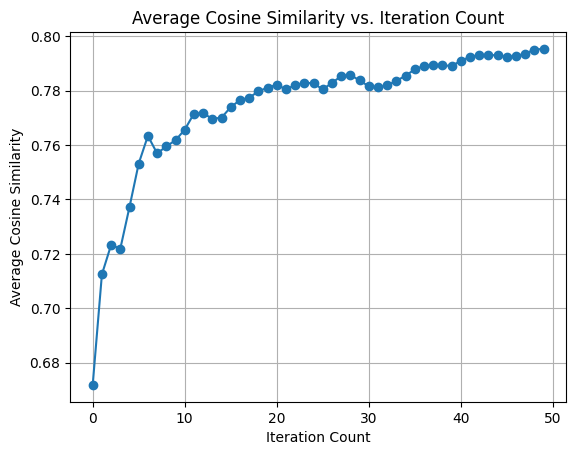

In [26]:
plt.plot(range(len(averages)), averages, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

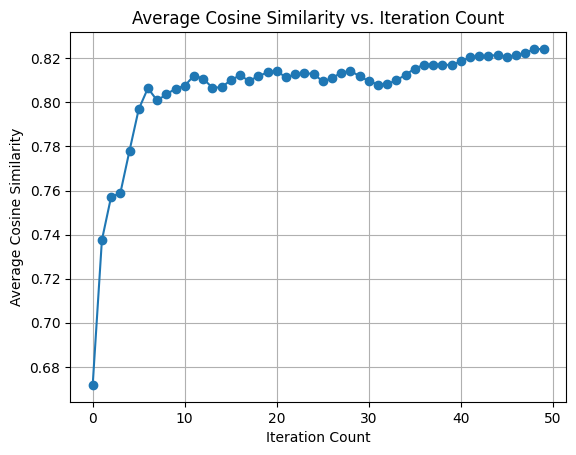

In [27]:
plt.plot(range(len(averages2)), averages2, marker='o')
plt.xlabel('Iteration Count')
plt.ylabel('Average Cosine Similarity')
plt.title('Average Cosine Similarity vs. Iteration Count')
plt.grid(True)
plt.show()

In [23]:
import pickle
df_know_embed.to_csv("know-space_withoutFBloop_ConMemNo.csv")
df_con = pd.DataFrame(concept_space, columns = ['concepts'])
df_con.to_csv("con-space_withoutFBloop_ConMemNo.csv")
with open('avg_iter_sim_withoutFBloop_ConMemNo.pkl', 'wb') as file:
    pickle.dump(avg_iteration_sim, file)
with open('sim_list_withoutFBloop_ConMemNo.pkl', 'wb') as file:
    pickle.dump(similarity_lists, file)
with open('past_transitions_withoutFBloop_ConMemNo-gpt4o.pkl', 'wb') as file:
    pickle.dump(past_transitions, file)

In [ ]:
def visualize_graph(system):
        """Draws the concept-knowledge transformation graph."""
        plt.figure(figsize=(12, 7))
        pos = nx.spring_layout(system.graph)
        labels = nx.get_edge_attributes(system.graph, "transition")

        nx.draw(system.graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=10)
        nx.draw_networkx_edge_labels(system.graph, pos, edge_labels=labels, font_size=9)
        plt.title("Concept-Knowledge Transformation Graph")
        plt.show()